# Workflow for the stringApp Exercise 3

### Import the required packages

In [19]:
## based on the tutorial https://jensenlab.org/training/stringapp/#exercise-3

import os
import sys
from time import sleep
import pandas as pd
import matplotlib
from py2cytoscape import cyrest
from IPython.display import Image
%matplotlib inline

### Setup Cytoscape
TODO: check if apps are installed and if not, install them

In [4]:
cytoscape=cyrest.cyclient()
cytoscape.version()

(u'cytoscapeVersion', u'3.7.2')
(u'apiVersion', u'v1')


In [5]:
cytoscape.session.new()

### Read the data as a table in Python
In this exercise, we will work with a list of 541 proteins associated with epithelial ovarian cancer (EOC) as identified by phosphoproteomics in the study by Francavilla et al.. An adapted, simplified version of their results table can be downloaded here.

In [9]:
## read table
fileName="Francavilla2017CellRep.tsv"
fileRead=pd.read_table(fileName,sep="\t")
fileRead.head()

,UniProt,Gene name,Modified sequence,AA position,EOC,FTE,OSE,EOC vs FTE,EOC vs OSE,Adj p-value,Cluster
0,O15439,ABCC4,_KDNEESEQPPVPGT(ph)PTLR_,T646,25.72,27.83,28.18,-2.11,-2.46,0.031600,A
1,Q9UKV3,ACIN1,_SSSISEEKGDS(ph)DDEKPR_,S118,24.82,25.54,22.18,-0.72,2.64,0.021500,B
2,Q9UKV3,ACIN1,_AAKLS(ph)EGS(ph)QPAEEEEDQETPSR_,S145,26.22,25.02,23.24,1.21,2.98,0.010800,C
3,Q9UKV3,ACIN1,_SKS(ph)PS(ph)PPRLTEDR_,S290,26.00,23.46,22.82,2.53,3.17,0.020600,C
4,Q9UKV3,ACIN1,_RLS(ph)QPESAEK_,S614,30.20,26.98,25.94,3.23,4.27,0.000913,C


### Protein network retrieval
Retrieve a STRING network for all UniProt identifiers in the table. 

In [10]:
UniprotIds=",".join(list(set(fileRead['UniProt'])))

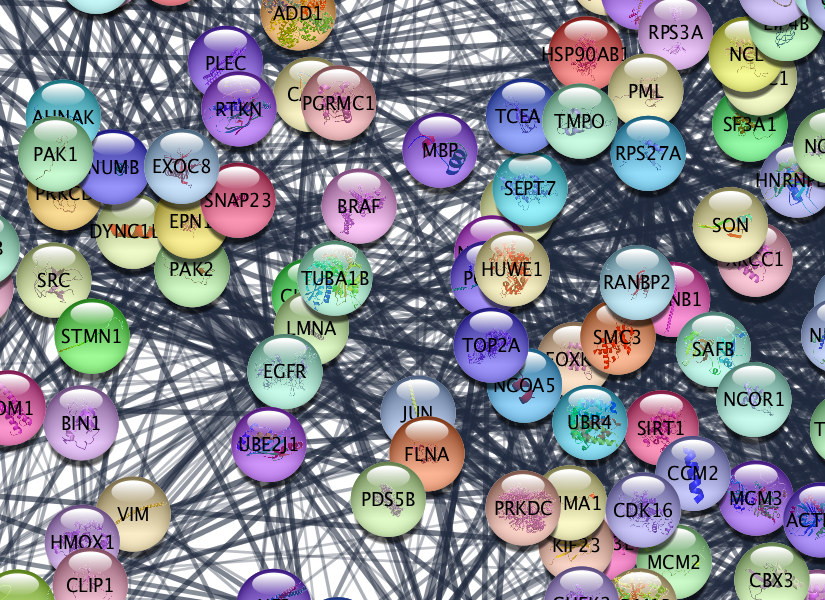

In [11]:
from py2cytoscape.cyrest.base import api
## create the string network with the uniprot ids
api(namespace="string",command="protein query",PARAMS={"cutoff": "0.4",
                                                      "limit": "0",
                                                      "newNetName": "EOC Network",
                                                      "query": UniprotIds,
                                                      "species": "homo sapiens",
                                                      "taxonID": "9606"})
sleep(2)
fig=cytoscape.networks.getFirstImageAsPng(networkId=cytoscape.network.get()["SUID"],h=None)
Image(fig.content)

### Discrete color mapping
Cytoscape allows you to map attributes of the nodes and edges to visual properties such as node color and edge width. Here, we will map drug target family data from the Pharos database to the node color. This data is contained in the node attribute called target family.

In [12]:
## get list of the available target families and define colors
family_type=list(set(cytoscape.table.getTable(columns=['target::family'],table='node')['target::family']))
family_colors=["grey", "green", "red", "blue"]
family_type

[None, u'GPCR', u'Ion Channel', u'Kinase']

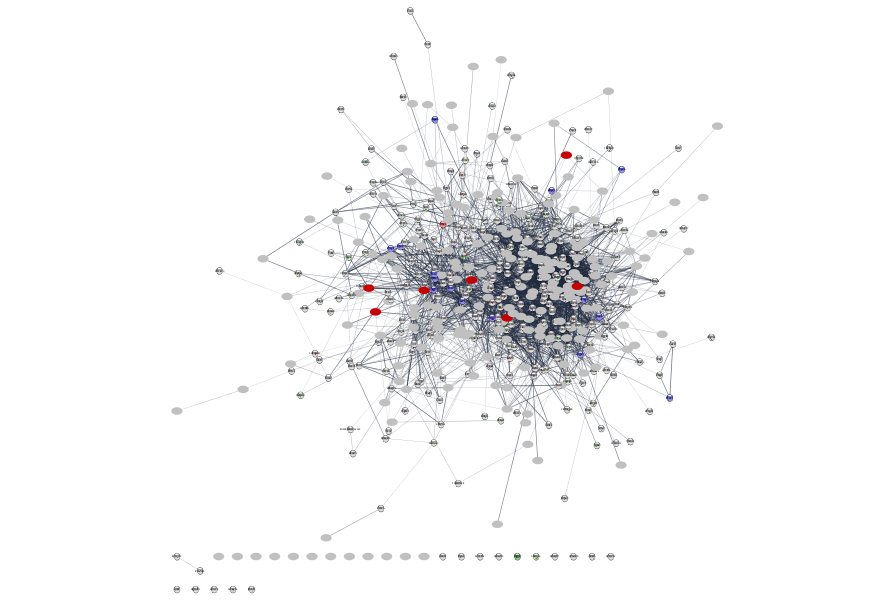

In [13]:
## mapping with discrete color
NODE_FILL_COLOR=cytoscape.vizmap.mapVisualProperty(visualProperty='NODE_FILL_COLOR',mappingType="discrete",\
                                                   mappingColumn='target::family', discrete=[family_type,family_colors])
cytoscape.vizmap.update_style(title="STRING style v1.5 - EOC Network",mappings=[NODE_FILL_COLOR])
cytoscape.vizmap.apply(styles="STRING style v1.5 - EOC Network")
fig=cytoscape.networks.getFirstImageAsPng(networkId=cytoscape.network.get()["SUID"],h=None)
Image(fig.content)

### Filtering nodes
There are many kinases in the network. We can avoid counting them manually by creating a selection filter.

In [15]:
##TODO: not working.. check again.......

api(namespace='filter', command="create", PARAMS={
  "name" : "Default filter",
  "transformers" : [ {
    "id" : "org.cytoscape.CompositeFilter",
    "parameters" : {
      "type" : "ALL"
    },
    "transformers" : [ {
      "id" : "org.cytoscape.ColumnFilter",
      "parameters" : {
        "predicate" : "IS",
        "criterion" : "KINASE",
        "caseSensitive" : "false",
        "type" : "nodes",
        "anyMatch" : "true",
        "columnName" : "target::family"
      }
    } ]
  } ]
})
api(namespace='filter',command='apply',PARAMS={'name':'Default filter',"network": "current"})
#sleep(2)
#fig=cytoscape.networks.getFirstImageAsPng(networkId=cytoscape.network.get()["SUID"],h=None)
#Image(fig.content)

### Data import into Cytoscape
Network nodes and edges can have additional information associated with them that we can load into Cytoscape and use for visualization. We will import the data from the table.

In [16]:
## select one entry for each protein (this table is special since it contains more than one entry for each protein)
protSet=set(fileRead['UniProt'])
print(len(protSet))
index_prot=[list(fileRead['UniProt']).index(each) for each in protSet]
selected_set=fileRead.iloc[index_prot]

541


In [17]:
## import data table in the network
cytoscape.table.loadTableData(selected_set,df_key='UniProt',table="node",table_key_column="query term")

''

### Continuous color mapping
Now, we want to color the nodes according to the quantitative phosphorylation data (log ratio) between disease and healthy tissues for the most significant site for each protein. 

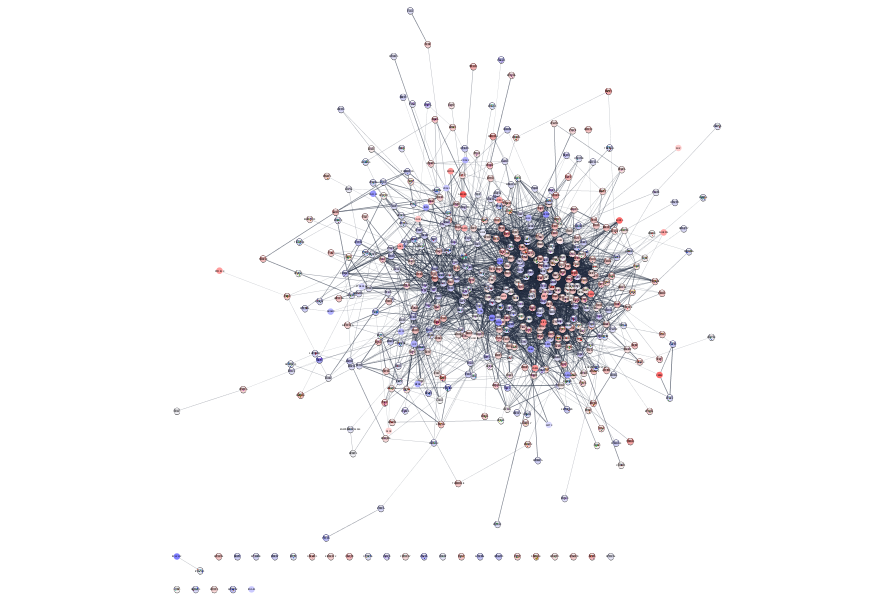

In [20]:
## get table with expr values
logFC = cytoscape.table.getTable(columns=['EOC vs FTE'],table='node')
#logFC.head()

## define min and max and corresponding colors
min_expr = min(logFC.dropna()['EOC vs FTE'].tolist())
max_expr = max(logFC.dropna()['EOC vs FTE'].tolist())
max_expr_mapping=max([abs(min_expr),abs(max_expr)])
min_expr_mapping=max_expr_mapping*-1.0
cmap = matplotlib.cm.get_cmap("bwr")
norm = matplotlib.colors.Normalize(vmin=min_expr_mapping, vmax=max_expr_mapping)
min_color=matplotlib.colors.rgb2hex(cmap(norm(min_expr_mapping)))
center_color=matplotlib.colors.rgb2hex(cmap(norm(0)))
max_color=matplotlib.colors.rgb2hex(cmap(norm(max_expr_mapping)))
#print(min_color, center_color, max_color)

## define mapping
NODE_FILL_COLOR=cytoscape.vizmap.mapVisualProperty(visualProperty='NODE_FILL_COLOR',mappingType="continuous",\
                                                   mappingColumn='EOC vs FTE',lower=[min_expr_mapping,min_color],\
                                                   center=[0.0,center_color],upper=[max_expr_mapping,max_color])
## apply the mapping
cytoscape.vizmap.update_style(title="STRING style v1.5 - EOC Network",mappings=[NODE_FILL_COLOR])
cytoscape.vizmap.apply(styles="STRING style v1.5 - EOC Network")
sleep(2)

## create figure of the network with mapping
fig=cytoscape.networks.getFirstImageAsPng(networkId=cytoscape.network.get()["SUID"],h=None)
Image(fig.content)

### Network clustering
Next, we will use the MCL algorithm to identify clusters of tightly connected proteins within the network. 

In [22]:
## call clustering API
api(namespace='cluster', command='mcl', PARAMS={'attribute':'stringdb::score', 'inflation_parameter':'4', 'showUI':'true'})
sleep(2)

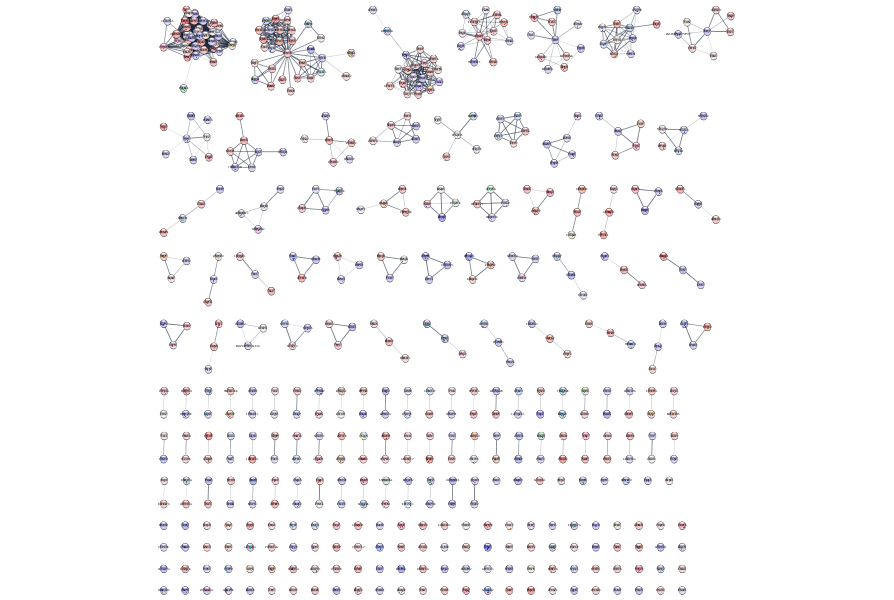

In [23]:
## create figure of resulting network
fig=cytoscape.networks.getFirstImageAsPng(networkId=cytoscape.network.get()["SUID"],h=None)
Image(fig.content)

### Functional enrichment
Next, we will retrieve functional enrichment for the proteins in our network of the top largest clusters. 

In [24]:
## now for each cluster create network and do string enrichment
cluster_names=cytoscape.table.getTable(columns=['__mclCluster'],table='node').sort_values(['__mclCluster'],ascending=[1])
cluster_names.head()

,__mclCluster
9606.ENSP00000317123,1.0
9606.ENSP00000376276,1.0
9606.ENSP00000261600,1.0
9606.ENSP00000345412,1.0
9606.ENSP00000349168,1.0


In [25]:
## to get the suid for the main network
clust_suid="SUID:"+str(cytoscape.network.get_attribute(columnList="SUID")[0]['SUID'])
clust_suid

'SUID:9520'

In [26]:
cytoscape.network.deselect(network=clust_suid, nodeList="all")

for clus in list(set(cluster_names['__mclCluster']))[1:8]:
    gene_list=cluster_names['__mclCluster'][cluster_names['__mclCluster']==clus].index.tolist()
    if len(gene_list)>0:
        print(len(gene_list))
        ## select the sub cluster and create a network
        cytoscape.network.select(nodeList="name:"+",".join(gene_list),network=clust_suid)
        cytoscape.network.create(nodeList="selected",source=clust_suid)
        ## now apply string enrichment on the selected network
        api(namespace='string',command='make string')
        ##retrieve enrichment
        api(namespace="string",command="retrieve enrichment")

        ## deselect all the nodes before another loop
        cytoscape.network.deselect(network=clust_suid, nodeList="all")
        
        
api(namespace="string",command="show enrichment")
        

47
27
18
13
11
10
8


In [27]:
## save the session
cytoscape.session.save_as(session_file="tringApp_tutorial_ex3")